In [12]:
import numpy as np
import scipy.linalg as la
import qiskit
qiskit.__version__

'1.2.0'

## ❗️ Develop, and if possible test and evaluate, an algorithm that solves the one-group, steady-state, slab geometry, fixed source diffusion equation.  Assume a spatial mesh is imposed on the problem and that a finite volume or finite difference discretization is used to derive the linear system of equations to be solved. 

# $- D \frac{d^2 \phi(x)}{dx^2} + \Sigma_a \, \phi(x) = S$


In [13]:
N = 9
n = N - 1
L = 10.0
dx = L / N
D = 1/3
xs_a = 0.1
S = 1.0 

def diffusion_matrix(D, xs_a): #finite difference
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2 * D / dx**2 + xs_a
        if i > 0:
            A[i, i - 1] = -D / dx**2
        if i < n - 1:
            A[i, i + 1] = -D / dx**2
    return A

A = diffusion_matrix(D, xs_a)
b = np.full(n, S * dx)
#b_norm = b / np.linalg.norm(b)

classical_solution = la.solve(A, b)
ref_solution = classical_solution / np.linalg.norm(classical_solution)
print("Classical solution:", classical_solution)
print("Reference solution:", ref_solution)
print("A", A)

Classical solution: [4.94670859 7.61030512 8.97730685 9.55401071 9.55401071 8.97730685
 7.61030512 4.94670859]
Reference solution: [0.2193634  0.33748145 0.39810158 0.4236757  0.4236757  0.39810158
 0.33748145 0.2193634 ]
A [[ 0.64 -0.27  0.    0.    0.    0.    0.    0.  ]
 [-0.27  0.64 -0.27  0.    0.    0.    0.    0.  ]
 [ 0.   -0.27  0.64 -0.27  0.    0.    0.    0.  ]
 [ 0.    0.   -0.27  0.64 -0.27  0.    0.    0.  ]
 [ 0.    0.    0.   -0.27  0.64 -0.27  0.    0.  ]
 [ 0.    0.    0.    0.   -0.27  0.64 -0.27  0.  ]
 [ 0.    0.    0.    0.    0.   -0.27  0.64 -0.27]
 [ 0.    0.    0.    0.    0.    0.   -0.27  0.64]]


In [ ]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
size = n
nqbit = int(np.log2(size))
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3)


In [15]:
# NOTE: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. 
# All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. 
# The V2 alternative for the `Estimator` class is `StatevectorEstimator`.


from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

# instantiate an estimator primitive
estimator = Estimator()

## create a logger
log = VQLSLog([], [])

# create the vqls solver
options = {"matrix_decomposition": "pauli", "verbose": True}
vqls = VQLS(estimator, ansatz, opt.CG(maxiter=200), options=options)

/var/folders/4c/d6_2w_n17m107k5fsh4ggp3w0000gn/T/ipykernel_41559/3220433378.py:11: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [16]:
res = vqls.solve(A, b)


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:00<00:00, 3792.37it/s]


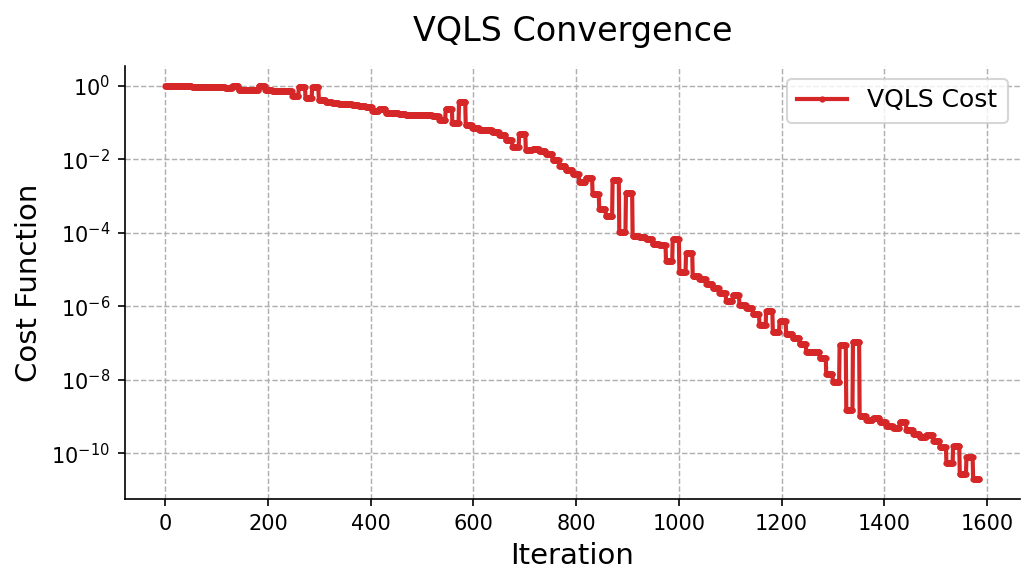

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4), dpi=150)
plt.semilogy(
    vqls.logger.values, 
    marker="o", 
    markersize=2, 
    linewidth=2, 
    label="VQLS Cost",
    color="tab:red"
)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)
    
plt.ylabel("Cost Function", fontsize=14)
plt.xlabel("Iteration", fontsize=14)
plt.title("VQLS Convergence", fontsize=16, pad=12)
plt.grid(which='both', linestyle='--', linewidth=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [23]:
from qiskit.quantum_info import Statevector

vqls_solution = np.real(Statevector(res.state).data)

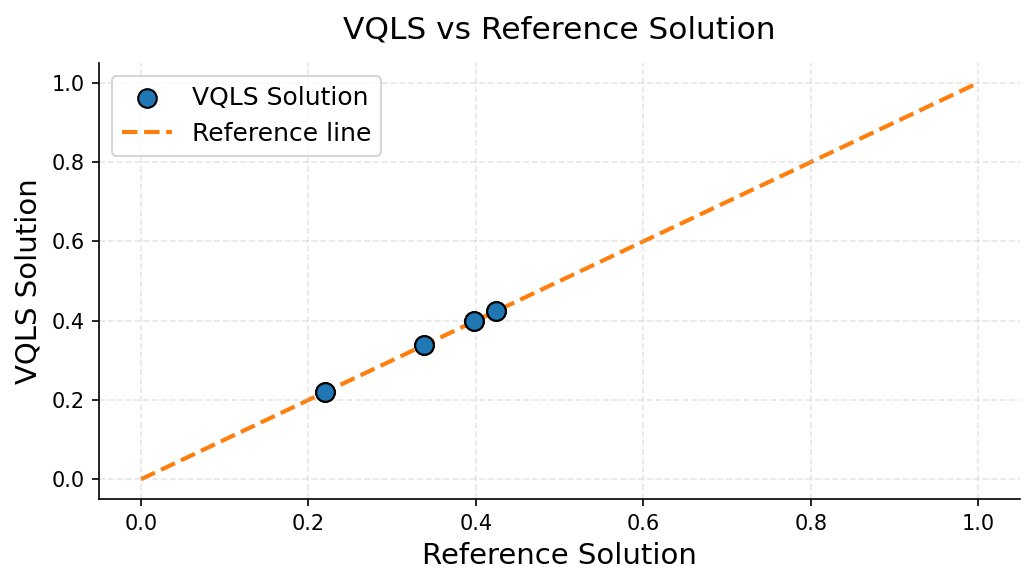

In [24]:
plt.figure(figsize=(7, 4), dpi=150)

# VQLS vs Reference
plt.scatter(
    ref_solution, vqls_solution, 
    label="VQLS Solution", 
    color="C0", s=80, edgecolor="k", zorder=2
)

# ref line x=y
plt.plot(
    [0, 1], [0, 1], 
    '--', 
    label="Reference line", 
    color="C1", linewidth=2, zorder=1
)

plt.xlabel("Reference Solution", fontsize=14)
plt.ylabel("VQLS Solution", fontsize=14)
plt.title("VQLS vs Reference Solution", fontsize=15, pad=12)
plt.legend(fontsize=12, loc="upper left", frameon=True)
plt.grid(alpha=0.3, linestyle="--")

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [25]:
print(ref_solution)

[0.2193634  0.33748145 0.39810158 0.4236757  0.4236757  0.39810158
 0.33748145 0.2193634 ]


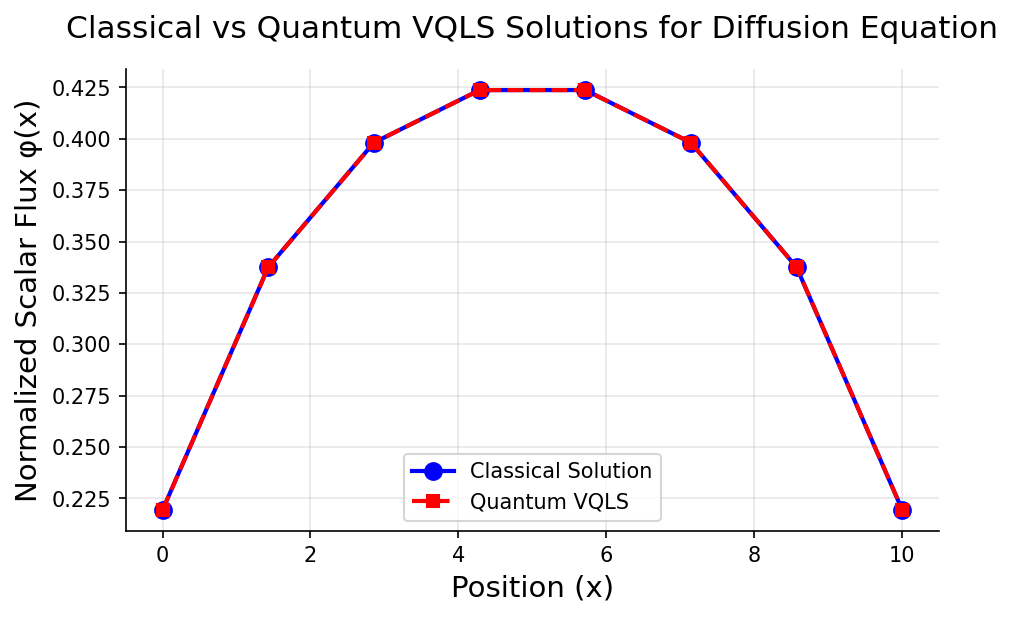

In [26]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(0, 10, 8)

plt.figure(figsize=(7, 4), dpi=150)
plt.plot(x, ref_solution, 'b-o', label='Classical Solution', markersize=8, linewidth=2)
plt.plot(x, vqls_solution, 'r--s', label='Quantum VQLS', markersize=6, linewidth=2)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.xlabel('Position (x)', fontsize=14)
plt.ylabel('Normalized Scalar Flux φ(x)', fontsize=14)
plt.title('Classical vs Quantum VQLS Solutions for Diffusion Equation', fontsize=15, pad=15)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()